In [1]:
%config Completer.use_jedi = True

In [2]:
# https://medium.com/analytics-vidhya/feature-selection-using-scikit-learn-5b4362e0c19b
# https://towardsdatascience.com/rank-the-features-now-rank-again-4dafd8cde3c8

In [3]:
ROOT_DIR = ".."
DATASET_DIR = "{}/datasets".format(ROOT_DIR)
DATASET_DIR

'../datasets'

In [4]:
### Use LightGBM

# ### Using ML/DL libraries
# 1. OpenChem
# 2. ChemProp
# 3. DeepChem

In [5]:
import os
import sys


from matplotlib import pyplot
import numpy as np
import pandas as pd
from pprint import pprint
import re

from scipy import stats
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb


ROOT_DIR = os.pardir
sys.path.insert(0, os.path.abspath(ROOT_DIR))

# Display pipelines and other objects
from sklearn import set_config
set_config(display="diagram")

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [6]:
def detect_outlier_z_scores(df):
  """
  To perform outlier detection, we are going to employ the Z-Score method because it is the simplest one.
  This s a slight modification of the code from the following link
  https://www.kaggle.com/alexandrehsd/binary-multiclass-classification-factor-analysis/notebookSS
  """
  flag_outlier = False

    for feature in df:
        #print(feature)
        column = df[feature]
        mean = np.mean(column)
        std = np.std(column)
        z_scores = (column - mean) / std
        outliers = np.abs(z_scores) > 3
    
    n_outliers = sum(outliers)
    
    if n_outliers > 0:
        print("{} has {} outliers".format(feature, n_outliers))
        flag_outlier = True

    if not flag_outlier:
        print("\nThe dataset has no outliers.")
    
    return None

def remove_outliers_by_z_score(df:pd.DataFrame, threshold:int = 3):
    ## Find outliers for all features
    z = np.abs(stats.zscore(df))
    outliers = np.where(z > threshold)
    columns = df.columns.tolist()
    cols_with_outliers = [columns[i] for i in 
                         set(outliers[1].tolist())]
    
    print("Features with outliers ({}) : {}".format(len(cols_with_outliers), cols_with_outliers))
    print(outliers[0].size)
    
    ## Remove outliers
    print("\nRemoving {} rows...".format(  len(set(outliers[0].tolist()))   ))
    print(np.where(z <= threshold)[0].size)
    new_df = df[(z <= threshold).all(axis=1)]
    print(new_df.shape)
    return new_df





In [7]:
# #https://stackoverflow.com/questions/37685412/avoid-scaling-binary-columns-in-sci-kit-learn-standsardscaler

# transformer_pipeline = Pipeline(steps=[
#     ('feature_processing', FeatureUnion(transformer_list = [
#          ( 'no_transformation',
#               Pipeline(steps = [
#                  ('bcut_maccs_pubchem', FunctionTransformer(lambda data: data.loc[:, cols_bcut_maccs_pubchem + [target]]))
#               ])),
              
        
#         #numeric to transform
#         ('numeric', Pipeline(steps = [
#             ('select', FunctionTransformer(lambda data: data.loc[:, cols_to_transform])),
#             ('scale', StandardScaler())
#                     ]))        
#     ])  
#     )
# ])

# transformer_pipeline

In [17]:
dataset = pd.read_csv("{}/csv/sr-p53.csv".format(DATASET_DIR))
print(dataset.shape)
features = dataset.columns.tolist()
target = "Activity"
test_ratio = 0.3
random_state = 233233

pattern = re.compile("MACCS")
cols_bcut_maccs_pubchem = [x for x in dataset.columns.tolist() if not pattern.match(x) is None]
cols_to_transform = [y for y in features if not y in cols_bcut_maccs_pubchem]
cols_to_transform.remove(target)

dataset.dropna(inplace=True)
dataset = dataset.reset_index()
dataset.drop(["index"], axis=1, inplace=True)

# print("index" in dataset.columns.tolist())

dataset[cols_to_transform] = scale(dataset[cols_to_transform])
# dataset[cols_bcut_maccs_pubchem]

print(dataset.shape)

# dataset.iloc[:,1400:1500].info()

(1064, 1608)
(1037, 1608)


## Split Data

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
strat_train_set, strat_test_set = None, None
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)

for train_index, test_index in splitter.split(dataset, dataset[target]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set  = dataset.loc[test_index]
    print(len(train_index))
    print(len(test_index))

# strat_train_set.head()
X_train = strat_train_set[strat_train_set.columns.difference([target])]
y_train = strat_train_set[target]
X_test, y_test   = strat_test_set[strat_test_set.columns.difference([target])], strat_test_set[target]

# print("strat_train_set : \n{}".format(strat_train_set[target].value_counts()/len(strat_train_set)))
# print("strat_test_set  : \n{}".format(strat_test_set[target].value_counts()/len(strat_test_set)))

725
312


## Training with Random Forest
### Grid search 

In [18]:
kfold = 5
# scoring = {'f1': 'f1_weighted', 'jaccard':'jaccard'} #, 'accuracy': 'accuracy'
scoring = ['f1_weighted']
params_grid_rf = {  'bootstrap': [True]
                  , 'max_depth': [5, 10, 30, None]
                  , 'criterion': ['gini'] # , 'entropy'
                  , 'max_features': ['auto']
                  , 'min_samples_split': [5, 10]
                  , 'n_estimators': [100, 150, 300, 400]
#                   , 'min_impurity_decrease': [0.0, 0.1]
                 }

In [19]:
rfc = RandomForestClassifier(random_state=random_state)
grid_searcher = GridSearchCV(estimator = rfc, param_grid = params_grid_rf, cv = kfold, n_jobs = -1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=233233),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [5, 10, 30, None],
                         'max_features': ['auto'], 'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 300, 400]},
             return_train_score=True, scoring='f1_weighted')

In [20]:
best_rf_grid = grid_searcher.best_estimator_
best_rf_grid_train_score = f1_score(best_rf_grid.predict(X_train), y_train , average='weighted' ) 
best_rf_grid_test_score = f1_score(best_rf_grid.predict(X_test), y_test , average='weighted' )
print("Best RF pamateters: {}".format(grid_searcher.best_params_))
print("Best RF score: {}".format(grid_searcher.best_score_))
print("Best RF train score (F1-weigthed): {}".format(best_rf_grid_train_score))
print("Best RF test score (F1-weigthed): {}".format(best_rf_grid_test_score))

Best RF pamateters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100}
Best RF score: 0.7735019891508429
Best RF train score (F1-weigthed): 0.9972415368258009
Best RF test score (F1-weigthed): 0.7469379711079688


### Randomized search 

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 5)]
max_depth    = [int(x) for x in np.linspace(10, 110, num = 11)]

params_random_rf = {  'bootstrap': [True]
                  , 'max_depth': max_depth + [None]
                  , 'criterion': ['gini'] # , 'entropy'
                  , 'max_features': ['auto']
                  , 'min_samples_split': [5]
                  , 'n_estimators': n_estimators
                  , 'min_impurity_decrease': [0.0]
                  , 
                 }

In [15]:
random_searcher = rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = params_random_rf, n_iter = 16
                                                 , scoring= 'f1_weighted' , cv = kfold, verbose=2, random_state=random_state, n_jobs = -1)
random_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=100, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=40, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=107; tota

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=233233),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto'],
                                        'min_impurity_decrease': [0.0],
                                        'min_samples_split': [5],
                                        'n_estimators': [10, 107, 205, 302,
                                                         400]},
                   random_state=233233, scoring='f1_weighted', verbose=2)

In [24]:
best_rf_random = random_searcher.best_estimator_
print("Best RF pamateters: {}".format(random_searcher.best_params_))
print("Best RF score: {}".format(random_searcher.best_score_))
print("Best RF train score (F1-weigthed): {}".format(f1_score(best_rf_random.predict(X_train), y_train , average='weighted' )))
print("Best RF test score (F1-weigthed): {}".format(f1_score(best_rf_random.predict(X_test), y_test , average='weighted' )))


Best RF pamateters: {'n_estimators': 302, 'min_samples_split': 5, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Best RF score: 0.7734713022116313
Best RF train score (F1-weigthed): 0.9972415368258009
Best RF test score (F1-weigthed): 0.727639674241616


## Model explanation with SHAP

* Reference(s):
>- https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook \
>- https://onezero.blog/machine-learning-model-explanation-using-shapley-values/ \
>- https://www.datatrigger.org/post/interpretable_machine_learning_shap/ \
>- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html \
>- https://medium.com/analytics-vidhya/interpretability-of-machine-learning-models-9787cf8a3789 \
>- https://shap.readthedocs.io/en/latest/index.html \
>- https://www.kaggle.com/code/dansbecker/shap-values/tutorial \
>- https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

In [25]:
# import shap library
import shap

print(X_train.shape)
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_rf_random, feature_perturbation="interventional", model_output="raw")
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()


(725, 1607)


In [26]:
# The mean prediction of your model on the data (for each categorical outcome).
explainer.expected_value

array([0.50892441, 0.49107559])

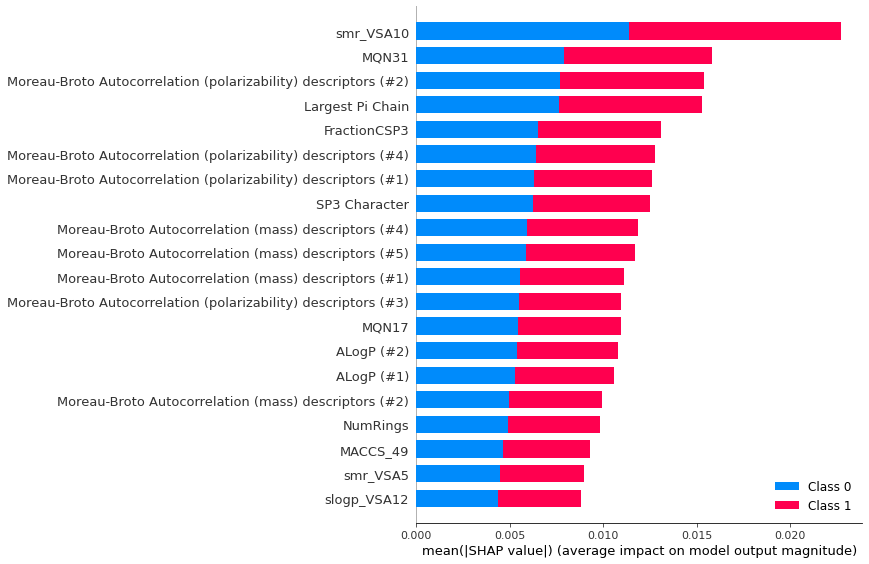

In [27]:
# Summary plot on the train set
shap.summary_plot(shap_values, X_train, plot_type='bar');

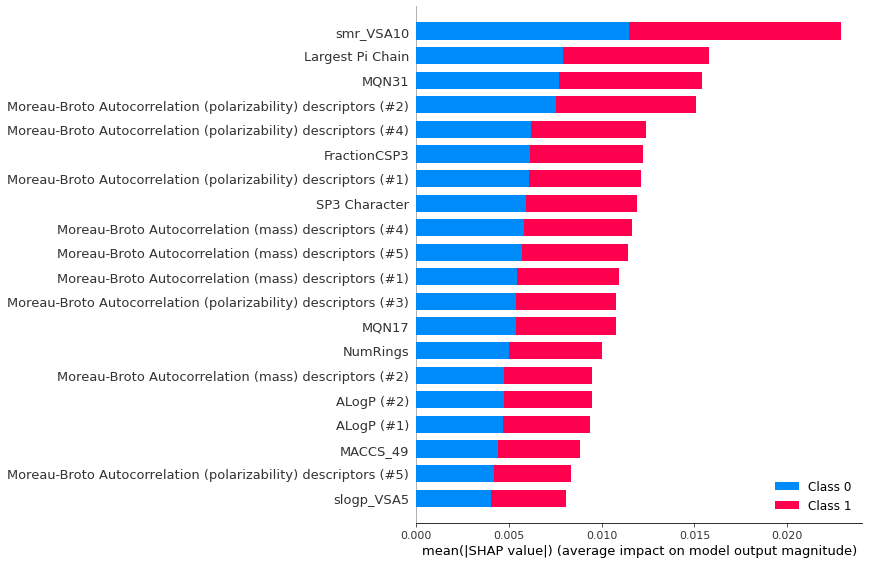

In [28]:
# Summary plot on the test set
shap_values_test = explainer.shap_values(X_test)
shap.summary_plot(shap_values_test, X_test, plot_type='bar');

In [29]:
## Explain the contribution of the first 20 features on the prediction of the whole data set
shap.force_plot(
    explainer.expected_value[0],  
    shap_values[0],
    X_train.iloc[:, :20]
)

In [30]:
# Shap values all all features for the first instance/row of the dataset
shap.force_plot(
    explainer.expected_value[0],  
    shap_values[0][0],
    X_train.iloc[:1, :]
)

### SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

* Reference(s):
>- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Explain-predictions

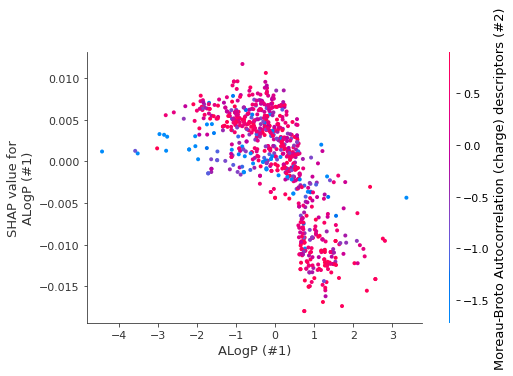

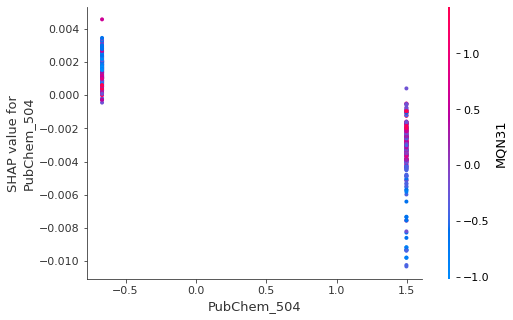

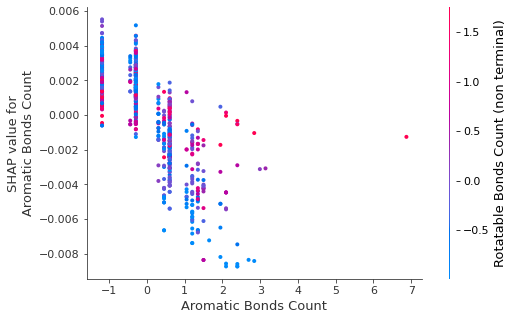

In [31]:
# Here we display the dependency plots of the featuees "ALogP (#1)", "PubChem_504", and "Aromatic Bonds Count" on the whole dataset

for name in ["ALogP (#1)", "PubChem_504", "Aromatic Bonds Count"]:
    shap.dependence_plot(name, shap_values[0], X_train, display_features=X_train)

## Training a voting classifier
The Voting Classifier class is not yet supported by SHAP

In [32]:
scoring = ['f1_weighted']
params_grid_rfc =  {  'bootstrap': [True]
                  , 'max_depth': [30, None]
                  , 'criterion': ['gini'] # , 'entropy'
                  , 'max_features': ['auto']
                  , 'min_samples_split': [5, 10]
                  , 'n_estimators': [150, 300]
                  , 'min_impurity_decrease': [0.0]
                 }

params_grid_svc = {
    'kernel': ['linear', 'sigmoid']
    , 'class_weight': ['balanced']
}

params_grid_gbc = {
              'n_estimators' : [100, 400]
              , 'learning_rate': [0.05]
              , 'max_depth': [None]
              , 'max_features': ['auto']
              , 'min_impurity_decrease': [0.0]
              }

In [33]:
rfc = RandomForestClassifier(random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)

# Given that we will use soft voting, which uses predicted probabilities for each class instead of 
# predicted labels, we must set the probability =True
svc = SVC(probability=True, random_state=random_state)


params = {}
params.update({"rfc__" + k: v for k, v in params_grid_rfc.items()})
params.update({"gbc__" + k: v for k, v in params_grid_gbc.items()})
params.update({"svc__" + k: v for k, v in params_grid_svc.items()})

ensemble_classifier = VotingClassifier(estimators=[("rfc", rfc),
                                    ("gbc", gbc),
                                    ("svc", svc)],
                        voting="soft")

ensemble_grid_searcher = GridSearchCV(estimator = ensemble_classifier , param_grid = params, cv = kfold, n_jobs = -1
                                      , verbose = 0, scoring = 'f1_weighted', return_train_score=True)

ensemble_grid_searcher.fit(X_train, y_train);

In [34]:
best_eclf_grid = ensemble_grid_searcher.best_estimator_

best_eclf_grid_train_score = f1_score(best_eclf_grid.predict(X_train), y_train , average='weighted' )
best_eclf_grid_test_score  = f1_score(best_eclf_grid.predict(X_test), y_test , average='weighted' )


print("Best pamateters: {}".format(ensemble_grid_searcher.best_params_))
print("Best score: {}".format(ensemble_grid_searcher.best_score_))
print("Best train score (F1-weigthed): {}".format(best_eclf_grid_train_score))
print("Best test score (F1-weigthed): {}".format(best_eclf_grid_test_score))

Best pamateters: {'gbc__learning_rate': 0.05, 'gbc__max_depth': None, 'gbc__max_features': 'auto', 'gbc__min_impurity_decrease': 0.0, 'gbc__n_estimators': 100, 'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_depth': 30, 'rfc__max_features': 'auto', 'rfc__min_impurity_decrease': 0.0, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 150, 'svc__class_weight': 'balanced', 'svc__kernel': 'linear'}
Best score: 0.7403094675137062
Best train score (F1-weigthed): 0.9986206581569372
Best test score (F1-weigthed): 0.7566910861883481


# Combining models trained with differently stratified splits.

## Create several splits based on selected features.
The splits can be based on different columns (activity, and some selected properties). For instance: 
* One mode trained on stratified split for 'Activity'
* Create bins for certain properties (e.g.: the 3-5 of the most important features based on SHAP), and build stratified train/test and train a model on it.

## Create train/test splits, and K-fold splits using Fingerprints through RDKit
* Reference(s):
>- **Picking Diverse Molecules Using Fingerprints (rdkit.SimDivFilters):** https://www.rdkit.org/docs/GettingStartedInPython.html
>- **Squonk: RDKit MaxMin Picker:** https://squonk.it/docs/cells/RDKit%20MaxMin%20Picker/
>- **Revisting the MaxMinPicker (2017)** http://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html
>- **RDKit Blog - MaxMinPicker**: https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb

In [31]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetAtomPairFingerprint, GetTopologicalTorsionFingerprint
from rdkit.Chem import PandasTools, MolFromSmiles
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [32]:
compounds_fname = "{}/compounds/nr-ahr.tab".format(ROOT_DIR)
compounds_df   = pd.read_csv(compounds_fname, sep='\t')
compounds_df.head()

,Compound,SMILES,activity
0,NCGC00013051-01,CC(C)(C)c1cc(O)ccc1O,1
1,NCGC00013051-05,CC(C)(C)c1cc(O)ccc1O,1
2,NCGC00013058-01,CN(C)c1ccc(cc1)C(c1ccccc1)=C1C=CC(C=C1)=[N+](C)C,1
3,NCGC00013260-01,COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c5ccccc5[...,1
4,NCGC00013289-01,OC(CCN1CCCCC1)(c1ccccc1)c1ccccc1,1


,Compound,SMILES,activity,Molecule
0,NCGC00013051-01,CC(C)(C)c1cc(O)ccc1O,1,

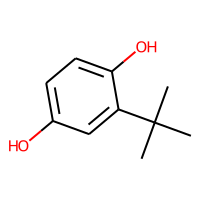

In [33]:
# smiles = smiles_df['SMILES']
# mols = [mol for mol in suppl if x is not None]
PandasTools.AddMoleculeColumnToFrame(compounds_df,'SMILES','Molecule',includeFingerprints=True)
compounds_df.iloc[:1,:]

### Interesting RDKit capabilitiy for subtrucutre search
A substructure filter can be applied on the dataframe using the RDKit molecule column, because the “>=” operator has been modified to work as a substructure check. Such the antibiotics containing the tributylamine group ("CCCCN(CCCC)CCCC") can be obtained by the call below:

In [34]:
tributylamine = MolFromSmiles("CCCCN(CCCC)CCCC")
mols_with_tributylamine = compounds_df[compounds_df['Molecule'] >=tributylamine]

,Compound,SMILES,activity,Molecule
101,NCGC00016833-01,CCCCN(CCC(O)c1cc2c(cc(Cl)cc2Cl)c2cc(ccc12)C(F)...,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
118,NCGC00016987-01,CN1[C@H]2[C@@H]3C[C@H]4[C@H](CC)[C@@H](O)N3[C@...,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
568,NCGC00247733-01,CC(C)(C)[C@@](C)(O)[C@H]1C[C@]23CC[C@@]1(OC)[C...,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

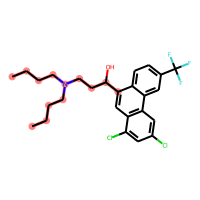
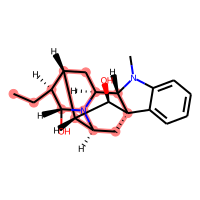
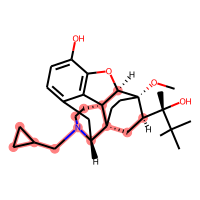

In [35]:
mols_with_tributylamine

### Doing the MixMax Picking
Pick() uses hierarchical clustering to pick compounds, while LazyPick() uses a user-defined function.

In [36]:
mols = [mol for mol in compounds_df['Molecule'] if not mol is None]
# n_compounds_to_pick = round(nfps*test_ratio)
picker = MaxMinPicker()

fp_types = { "morgan": "GetMorganFingerprint", "atom_pair": "GetAtomPairFingerprint", "top_torso": "GetTopologicalTorsionFingerprint"} 

#### MinMax Picking with Morgan Fingperprints

In [38]:
fps_morgan = [GetMorganFingerprint(x,3) for x in mols]
nfps_morgan = len(fps_morgan)
n_compounds_to_pick = round(nfps_morgan*test_ratio)
## Calculate the Dice dissimilarity between compounds
def distij(i,j,fps=fps_morgan):
    return 1-DataStructs.DiceSimilarity(fps_morgan[i],fps_morgan[j])

nfps_morgan = len(fps_morgan)
pickTestIndices_morgan = picker.LazyPick(distij, nfps_morgan, n_compounds_to_pick ,seed=random_state)
# list(pickTestIndices_morgan)
indices_in_dataset_morgan = [i for i in list(pickTestIndices_morgan) if i in dataset.index]
test_minmax_morgan = dataset.iloc[indices_in_dataset_morgan]
train_minmax_morgan = dataset[~dataset.index.isin(indices_in_dataset_morgan)]

X_train_minmax_morgan, y_train_minmax_morgan = train_minmax_morgan[train_minmax_morgan.columns.difference([target])], train_minmax_morgan[target]
X_test_minmax_morgan, y_test_minmax_morgan = test_minmax_morgan[test_minmax_morgan.columns.difference([target])], test_minmax_morgan[target]

In [39]:
print("Morgan:\n\tTrain: {}\n\tTest: {}".format(train_minmax_morgan.shape, test_minmax_morgan.shape))

Morgan:
	Train: (1315, 1608)
	Test: (567, 1608)


#### MinMax Picking with Atom Pair Fingperprints

In [40]:
fps_atom_pair = [GetAtomPairFingerprint(x) for x in mols]

## Calculate the Dice dissimilarity between compounds
def distij(i,j,fps=fps_atom_pair):
    return 1-DataStructs.DiceSimilarity(fps_atom_pair[i],fps_atom_pair[j])

nfps_atom_pair = len(fps_atom_pair)
pickTestIndices_atom_pair = picker.LazyPick(distij, nfps_atom_pair, n_compounds_to_pick ,seed=random_state)
# list(pickTestIndices_morgan)
indices_in_dataset_atom_pair = [i for i in list(pickTestIndices_atom_pair) if i in dataset.index]
test_minmax_atom_pair = dataset.iloc[indices_in_dataset_atom_pair]
train_minmax_atom_pair = dataset[~dataset.index.isin(indices_in_dataset_atom_pair)]

X_train_minmax_atom_pair, y_train_minmax_atom_pair = train_minmax_atom_pair[train_minmax_atom_pair.columns.difference([target])], train_minmax_atom_pair[target]
X_test_minmax_atom_pair, y_test_minmax_atom_pair = test_minmax_atom_pair[test_minmax_atom_pair.columns.difference([target])], test_minmax_atom_pair[target]

In [41]:
print("Atom Pair:\n\tTrain: {}\n\tTest: {}".format(train_minmax_atom_pair.shape, test_minmax_atom_pair.shape))

Atom Pair:
	Train: (1313, 1608)
	Test: (569, 1608)


#### MinMax Picking with Topological Torsional Fingperprints

In [42]:
fps_top_torso = [GetTopologicalTorsionFingerprint(x) for x in mols]

## Calculate the Dice dissimilarity between compounds
def distij(i,j,fps=fps_top_torso):
    return 1-DataStructs.DiceSimilarity(fps_top_torso[i],fps_top_torso[j])

nfps_top_torso = len(fps_top_torso)
pickTestIndices_top_torso = picker.LazyPick(distij, nfps_top_torso, n_compounds_to_pick ,seed=random_state)
# list(pickTestIndices_morgan)
indices_in_dataset_top_torso = [i for i in list(pickTestIndices_top_torso) if i in dataset.index]
test_minmax_top_torso = dataset.iloc[indices_in_dataset_top_torso]
train_minmax_top_torso = dataset[~dataset.index.isin(indices_in_dataset_top_torso)]

X_train_minmax_top_torso, y_train_minmax_top_torso = train_minmax_top_torso[train_minmax_top_torso.columns.difference([target])], train_minmax_top_torso[target]
X_test_minmax_top_torso, y_test_minmax_top_torso = test_minmax_top_torso[test_minmax_top_torso.columns.difference([target])], test_minmax_top_torso[target]

In [43]:
print("Topological Torsional:\n\tTrain: {}\n\tTest: {}".format(train_minmax_atom_pair.shape, test_minmax_atom_pair.shape))

Topological Torsional:
	Train: (1313, 1608)
	Test: (569, 1608)


In [44]:
intersecton_morgan_atom_pair = [p for p in indices_in_dataset_morgan if p in indices_in_dataset_atom_pair]
intersecton_morgan_top_torso = [p for p in indices_in_dataset_morgan if p in indices_in_dataset_top_torso]
intersecton_atom_pair_top_torso = [p for p in indices_in_dataset_atom_pair if p in indices_in_dataset_top_torso]
print(len(intersecton_morgan_atom_pair))
print("Morgan/AtomPair: {}".format(len(intersecton_morgan_atom_pair)/ len(set(indices_in_dataset_atom_pair+indices_in_dataset_morgan)) ))
print("Morgan/TopologicalTorsional: {}".format( len(intersecton_morgan_top_torso)/ len(set(indices_in_dataset_top_torso+indices_in_dataset_morgan))))
print("TopologicalTorsional/AtomPair: {}".format( len(intersecton_atom_pair_top_torso)/ len(set(indices_in_dataset_atom_pair+indices_in_dataset_top_torso))))

340
Morgan/AtomPair: 0.4271356783919598
Morgan/TopologicalTorsional: 0.445859872611465
TopologicalTorsional/AtomPair: 0.44472681067344344


### Training Models with Random Forests
#### After MinMax Picking with Morgan Fingperprints

In [45]:
rfc_morgan = RandomForestClassifier(random_state=random_state)
grid_searcher_morgan = GridSearchCV(estimator = rfc_morgan, param_grid = params_grid_rf, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
grid_searcher_morgan.fit(X_train_minmax_morgan, y_train_minmax_morgan)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=233233),
             n_jobs=1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [5, 10, 30, None],
                         'max_features': ['auto'], 'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 300]},
             return_train_score=True, scoring='f1_weighted')

In [46]:
best_rf_grid_morgan = grid_searcher_morgan.best_estimator_
best_rf_grid_morgan_train_score = f1_score(best_rf_grid_morgan.predict(X_train_minmax_morgan), y_train_minmax_morgan , average='weighted' )
best_rf_grid_morgan_test_score  = f1_score(best_rf_grid_morgan.predict(X_test_minmax_morgan), y_test_minmax_morgan , average='weighted' )
print("Best RF pamateters: {}".format(grid_searcher_morgan.best_params_))
print("Best RF score: {}".format(grid_searcher_morgan.best_score_))
print("Best RF train score (F1-weigthed): {}".format(best_rf_grid_morgan_train_score))
print("Best RF test score (F1-weigthed): {}".format(best_rf_grid_morgan_test_score))

Best RF pamateters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 300}
Best RF score: 0.825741681541138
Best RF train score (F1-weigthed): 0.9688335648375496
Best RF test score (F1-weigthed): 0.7716544377262525


In [47]:
############ SHAP
# explain the model's predictions using SHAP
explainer_rfc_morgan = shap.TreeExplainer(best_rf_grid_morgan, feature_perturbation="interventional", model_output="raw")
shap_values_train_morgan = explainer_rfc_morgan.shap_values(X_train_minmax_morgan)

Expected values: [0.49054246 0.50945754]


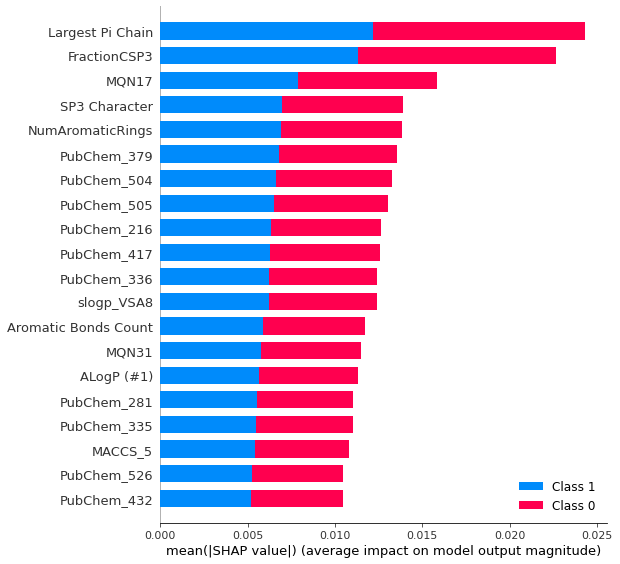

In [48]:
# Summary plot on the train set
print("Expected values: {}".format(explainer_rfc_morgan.expected_value))
shap.summary_plot(shap_values_train_morgan, X_train_minmax_morgan, plot_type='bar');

#### After MinMax Picking with Atom Pair Fingperprints

In [49]:
%time
rfc_atom_pair = RandomForestClassifier(random_state=random_state)
grid_searcher_atom_pair = GridSearchCV(estimator = rfc_atom_pair, param_grid = params_grid_rf, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
grid_searcher_atom_pair.fit(X_train_minmax_atom_pair, y_train_minmax_atom_pair)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=233233),
             n_jobs=1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [5, 10, 30, None],
                         'max_features': ['auto'], 'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 300]},
             return_train_score=True, scoring='f1_weighted')

In [50]:
best_rf_grid_atom_pair = grid_searcher_atom_pair.best_estimator_
best_rf_grid_atom_pair_train_score = f1_score(best_rf_grid_atom_pair.predict(X_train_minmax_atom_pair), y_train_minmax_atom_pair , average='weighted' )
best_rf_grid_atom_pair_test_score  = f1_score(best_rf_grid_atom_pair.predict(X_test_minmax_atom_pair), y_test_minmax_atom_pair , average='weighted' )

print("Best RF pamateters: {}".format(grid_searcher_atom_pair.best_params_))
print("Best RF score: {}".format(grid_searcher_atom_pair.best_score_))
print("Best RF train score (F1-weigthed): {}".format(best_rf_grid_atom_pair_train_score))
print("Best RF test score (F1-weigthed): {}".format(best_rf_grid_atom_pair_test_score))

Best RF pamateters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 300}
Best RF score: 0.8102334555992007
Best RF train score (F1-weigthed): 0.995430296357841
Best RF test score (F1-weigthed): 0.813806165320682


In [51]:
############ SHAP
# explain the model's predictions using SHAP
explainer_rfc_atom_pair = shap.TreeExplainer(best_rf_grid_atom_pair, feature_perturbation="interventional", model_output="raw")
shap_values_train_atom_pair = explainer_rfc_atom_pair.shap_values(X_train_minmax_atom_pair)

Expected values: [0.49808073 0.50191927]


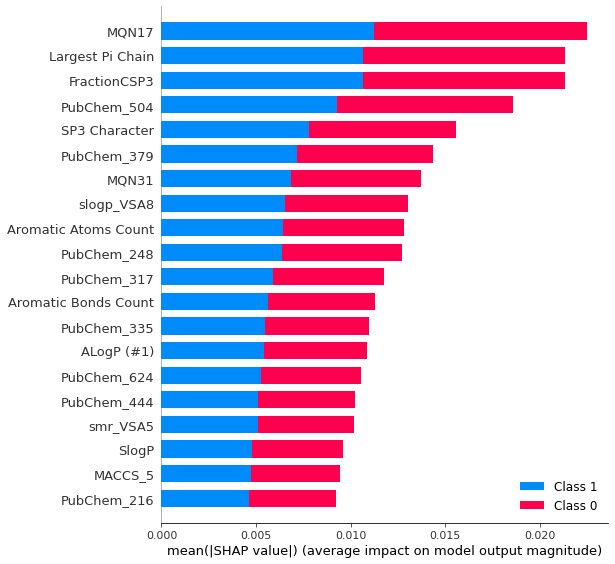

In [52]:
# Summary plot on the train set
print("Expected values: {}".format(explainer_rfc_atom_pair.expected_value))
shap.summary_plot(shap_values_train_atom_pair, X_train_minmax_atom_pair, plot_type='bar');

#### After MinMax Picking with Topological Torsional Fingperprints

In [53]:
%time
rfc_top_torso = RandomForestClassifier(random_state=random_state)
grid_searcher_top_torso = GridSearchCV(estimator = rfc_top_torso, param_grid = params_grid_rf, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
grid_searcher_top_torso.fit(X_train_minmax_top_torso, y_train_minmax_top_torso)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=233233),
             n_jobs=1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [5, 10, 30, None],
                         'max_features': ['auto'], 'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 300]},
             return_train_score=True, scoring='f1_weighted')

In [54]:
best_rf_grid_top_torso = grid_searcher_top_torso.best_estimator_
best_rf_grid_top_torso_train_score = f1_score(best_rf_grid_top_torso.predict(X_train_minmax_top_torso), y_train_minmax_top_torso , average='weighted' )
best_rf_grid_top_torso_test_score  = f1_score(best_rf_grid_top_torso.predict(X_test_minmax_top_torso), y_test_minmax_top_torso , average='weighted' )
print("Best RF pamateters: {}".format(grid_searcher_top_torso.best_params_))
print("Best RF score: {}".format(grid_searcher_top_torso.best_score_))
print("Best RF train score (F1-weigthed): {}".format(best_rf_grid_top_torso_train_score))
print("Best RF test score (F1-weigthed): {}".format(best_rf_grid_top_torso_test_score))

Best RF pamateters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 150}
Best RF score: 0.8160861822528085
Best RF train score (F1-weigthed): 0.9946726531212816
Best RF test score (F1-weigthed): 0.8240659733707116


In [55]:
############ SHAP
# explain the model's predictions using SHAP
explainer_rfc_top_torso = shap.TreeExplainer(best_rf_grid_top_torso, feature_perturbation="interventional", model_output="raw")
shap_values_train_top_torso = explainer_rfc_top_torso.shap_values(X_train_minmax_top_torso)

Expected values: [0.49528666 0.50471334]


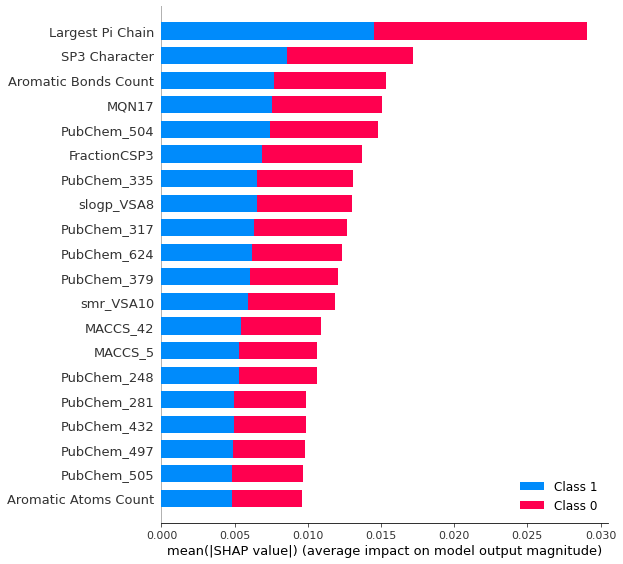

In [56]:
# Summary plot on the train set
print("Expected values: {}".format(explainer_rfc_top_torso.expected_value))
shap.summary_plot(shap_values_train_top_torso, X_train_minmax_top_torso, plot_type='bar');

#### Combining the best estimators
Training and evaluation will be made on a random train/test split.

In [57]:
rfc_models = list()
rfc_models.append(('best_rf_grid_morgan', best_rf_grid_morgan))
rfc_models.append(('best_rf_grid_atom_pair', best_rf_grid_atom_pair))
rfc_models.append(('best_rf_grid_top_torso', best_rf_grid_top_torso))


<p style="color:green; font-size:12"><b>Hard Voting</b></p>

In [58]:
%time
rfc_ensemble_hard = VotingClassifier(rfc_models, voting='hard')
rfc_ensemble_hard.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


VotingClassifier(estimators=[('best_rf_grid_morgan',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=233233)),
                             ('best_rf_grid_atom_pair',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=233233)),
                             ('best_rf_grid_top_torso',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_split=5,
                                                     n_estimators=150,
                                                     random_state=233233))])

In [59]:
print("Hard Voter Train Score (F1-weigthed): {}".format(f1_score(rfc_ensemble_hard.predict(X_train), y_train , average='weighted' )))
print("Hard Voter Test Score (F1-weigthed): {}".format(f1_score(rfc_ensemble_hard.predict(X_test), y_test , average='weighted' )))

Hard Voter Train Score (F1-weigthed): 0.9924069855732726
Hard Voter Test Score (F1-weigthed): 0.8425124285501354


<p style="color:green; font-size:12"><b>Soft Voting</b></p>

In [61]:
%time
rfc_ensemble_soft = VotingClassifier(rfc_models, voting='soft')
rfc_ensemble_soft.fit(X_train, y_train)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.72 µs


VotingClassifier(estimators=[('best_rf_grid_morgan',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=233233)),
                             ('best_rf_grid_atom_pair',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=233233)),
                             ('best_rf_grid_top_torso',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_split=5,
                                                     n_estimators=150,
                                                     random_state=233233))],
                 voting='soft')

In [62]:
rfc_ensemble_soft_train_score = f1_score(rfc_ensemble_soft.predict(X_train), y_train , average='weighted' )
rfc_ensemble_soft_test_score  = f1_score(rfc_ensemble_soft.predict(X_test), y_test , average='weighted' )
print("Soft Voter Train Score (F1-weigthed): {}".format(rfc_ensemble_soft_train_score))
print("Soft Voter Test Score (F1-weigthed): {}".format(rfc_ensemble_soft_test_score))

Soft Voter Train Score (F1-weigthed): 0.9886105440286928
Soft Voter Test Score (F1-weigthed): 0.8425311929422975


In [107]:
print("This soft voting ensemble classifier was built using three random forest classifiers trained on train/test \
split obtained using different compound selection method. Its weighted **F1 score is {}**, which is higher than the \
**F1 score ({})** of the previous soft voting ensemble classifier that combibed a random forest classifier, a \
support vector classifier, and a gradient boosting classifier.".format(rfc_ensemble_soft_test_score, best_eclf_grid_test_score))

# Interesting notes

In [ ]:
print("1) Diversification w.r.t. splitting technique could provide better results compared to diversification w.r.t classification algortihms.")
print("2) Splitting train/test sets with MinMax diversity selection could improve model performance over random splitting.")
print("3) The best random forest models achieved a weighted F1-score of {} (RF random split),\
{} (Morgan FP Pick), {} (Atom Pair FP Pick), {} (Topol. Torsional Pick)".format(best_rf_grid_test_score, best_rf_grid_morgan_test_score
                                                                                , best_rf_grid_atom_pair_test_score, best_rf_grid_top_torso_test_score))
print("It would be interesting to know if this could be replicated with other datasets and algorithms.")

## Training Models with XGBoost
#### On a Stratified Random Split (based on target)

In [ ]:
params_grid_xgb = {
#                 'nthread':[2], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [10, 6],
              'min_child_weight': [1, 5],
              'silent': [1],
              'subsample': [0.75],
              'colsample_bytree': [0.7],
              'n_estimators': [300], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [random_state]}

In [84]:
xgb_model = xgb.XGBClassifier(verbosity=0)

In [85]:
%time
grid_searcher_xgb = GridSearchCV(xgb_model, params_grid_xgb
                   , cv = kfold, n_jobs = -1, verbose = 2, scoring = 'f1_weighted', return_train_score=True)
grid_searcher_xgb.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.7min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=25.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=25.1min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=25.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=25.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=11.1min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=10.8min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=10.9min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=25.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=10.7min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=10.8min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=17.8min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=17.8min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=18.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=18.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.5min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=17.7min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.1min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=21.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=21.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=21.4min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time= 9.2min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=21.0min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=21.1min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time= 9.5min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time= 9.5min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time= 9.6min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=150, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time= 9.3min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.6min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.6min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=16.7min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=12.1min


/home/jovyan/anaconda3/envs/chemkube/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, missing=-999, n_estimators=300, objective=binary:logistic, seed=233233, silent=1, subsample=0.75; total time=10.0min


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=0),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [10, 6], 'min_child_weight': [1, 5],
                         'missing': [-999], 'n_estimators': [150, 300],
                         'objective': ['binary:logistic'], 'seed': [233233],
                         'silent': [1], 'subsample': [0.75]},
             return_train_score=True, scoring='f1_weighted', verbose=2)

In [90]:
best_xgb_grid = grid_searcher_xgb.best_estimator_
best_xgb_grid_train_score = f1_score(best_xgb_grid.predict(X_train), y_train , average='weighted' ) 
best_xgb_grid_test_score = f1_score(best_xgb_grid.predict(X_test), y_test , average='weighted' )
print("Best XGB pamateters: {}".format(grid_searcher_xgb.best_params_))
print("Best XGB score: {}".format(grid_searcher_xgb.best_score_))
print("Best XGB train score (F1-weigthed): {}".format(best_xgb_grid_train_score))
print("Best XGB test score (F1-weigthed): {}".format(best_xgb_grid_test_score))

Best XGB pamateters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 150, 'objective': 'binary:logistic', 'seed': 233233, 'silent': 1, 'subsample': 0.75}
Best XGB score: 0.8319694076692237
Best XGB train score (F1-weigthed): 0.9984813971146546
Best XGB test score (F1-weigthed): 0.8425124285501354


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


#### After MinMax Picking with Morgan Fingperprints

In [91]:
%time
xgb_morgan = xgb.XGBClassifier(verbosity=0)
xgb_grid_searcher_morgan = GridSearchCV(estimator = xgb_morgan, param_grid = params_grid_xgb, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
xgb_grid_searcher_morgan.fit(X_train_minmax_morgan, y_train_minmax_morgan)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=0),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [10, 6], 'min_child_weight': [1, 5],
                         'missing': [-999], 'n_estimators': [150, 300],
                         'objective': ['binary:logistic'], 'seed': [233233],
                         'silent': [1], 'subsample': [0.75]},
             return_train_score=True, scoring='f1_weighted')

In [92]:
best_xgb_grid_morgan = xgb_grid_searcher_morgan.best_estimator_
best_xgb_grid_morgan_train_score = f1_score(best_xgb_grid_morgan.predict(X_train_minmax_morgan), y_train_minmax_morgan , average='weighted' )
best_xgb_grid_morgan_test_score  = f1_score(best_xgb_grid_morgan.predict(X_test_minmax_morgan), y_test_minmax_morgan , average='weighted' )
print("Best XGB pamateters: {}".format(xgb_grid_searcher_morgan.best_params_))
print("Best XGB score: {}".format(grid_searcher_morgan.best_score_))
print("Best XGB train score (F1-weigthed): {}".format(best_xgb_grid_morgan_train_score))
print("Best XGB test score (F1-weigthed): {}".format(best_xgb_grid_morgan_test_score))

Best XGB pamateters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 233233, 'silent': 1, 'subsample': 0.75}
Best XGB score: 0.825741681541138
Best XGB train score (F1-weigthed): 0.9977186021459522
Best XGB test score (F1-weigthed): 0.8255870290773013


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


#### After MinMax Picking with Atom Pair Fingperprints

In [93]:
%time
xgb_atom_pair = xgb.XGBClassifier(verbosity=0)
xgb_grid_searcher_atom_pair = GridSearchCV(estimator = xgb_atom_pair, param_grid = params_grid_xgb, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
xgb_grid_searcher_atom_pair.fit(X_train_minmax_atom_pair, y_train_minmax_atom_pair)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=0),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [10, 6], 'min_child_weight': [1, 5],
                         'missing': [-999], 'n_estimators': [150, 300],
                         'objective': ['binary:logistic'], 'seed': [233233],
                         'silent': [1], 'subsample': [0.75]},
             return_train_score=True, scoring='f1_weighted')

In [94]:
best_xgb_grid_atom_pair = xgb_grid_searcher_atom_pair.best_estimator_
best_xgb_grid_atom_pair_train_score = f1_score(best_xgb_grid_atom_pair.predict(X_train_minmax_atom_pair), y_train_minmax_atom_pair , average='weighted' )
best_xgb_grid_atom_pair_test_score  = f1_score(best_xgb_grid_atom_pair.predict(X_test_minmax_atom_pair), y_test_minmax_atom_pair , average='weighted' )
print("Best XGB pamateters: {}".format(xgb_grid_searcher_atom_pair.best_params_))
print("Best XGB score: {}".format(grid_searcher_atom_pair.best_score_))
print("Best XGB train score (F1-weigthed): {}".format(best_xgb_grid_atom_pair_train_score))
print("Best XGB test score (F1-weigthed): {}".format(best_xgb_grid_atom_pair_test_score))

Best XGB pamateters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 233233, 'silent': 1, 'subsample': 0.75}
Best XGB score: 0.8102334555992007
Best XGB train score (F1-weigthed): 0.9977151481789434
Best XGB test score (F1-weigthed): 0.8207348149576397


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [95]:
############ SHAP
# explain the model's predictions using SHAP
explainer_xgb_atom_pair = shap.TreeExplainer(best_xgb_grid_atom_pair, feature_perturbation="interventional", model_output="raw")
shap_values_train_atom_pair = explainer_xgb_atom_pair.shap_values(X_train_minmax_atom_pair)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Expected values: -0.10065897554159164


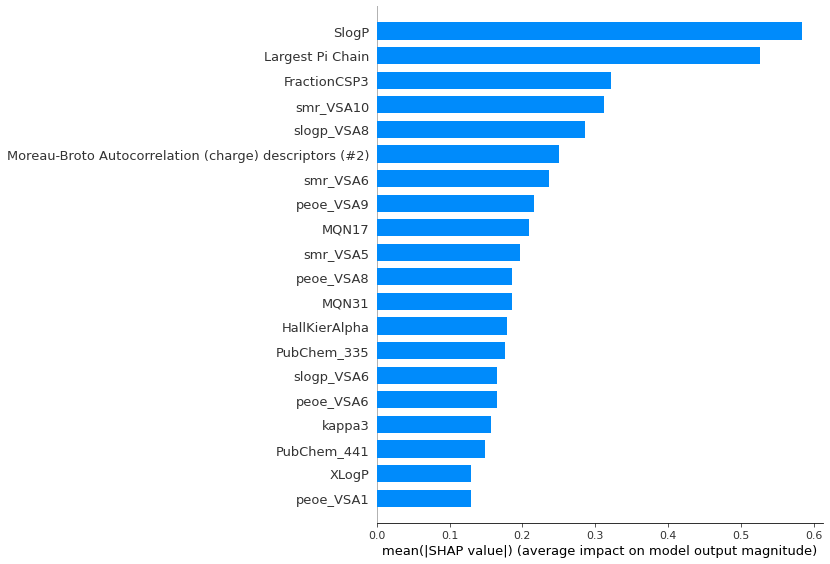

In [96]:
# Summary plot on the train set
print("Expected values: {}".format(explainer_xgb_atom_pair.expected_value))
shap.summary_plot(shap_values_train_atom_pair, X_train_minmax_atom_pair, plot_type='bar');

#### After MinMax Picking with Topological Torsional Fingperprints

In [97]:
%time
xgb_top_torso = xgb.XGBClassifier(verbosity=0)
xgb_grid_searcher_top_torso = GridSearchCV(estimator = xgb_top_torso, param_grid = params_grid_xgb, cv = kfold, n_jobs = 1, verbose = 0, scoring = 'f1_weighted', return_train_score=True)
xgb_grid_searcher_top_torso.fit(X_train_minmax_top_torso, y_train_minmax_top_torso)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=0),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [10, 6], 'min_child_weight': [1, 5],
                         'missing': [-999], 'n_estimators': [150, 300],
                         'objective': ['binary:logistic'], 'seed': [233233],
                         'silent': [1], 'subsample': [0.75]},
             return_train_score=True, scoring='f1_weighted')

In [98]:
best_xgb_grid_top_torso = xgb_grid_searcher_top_torso.best_estimator_
best_xgb_grid_top_torso_train_score = f1_score(best_xgb_grid_top_torso.predict(X_train_minmax_top_torso), y_train_minmax_top_torso , average='weighted' )
best_xgb_grid_top_torso_test_score  = f1_score(best_xgb_grid_top_torso.predict(X_test_minmax_top_torso), y_test_minmax_top_torso , average='weighted' )
print("Best XGB pamateters: {}".format(xgb_grid_searcher_top_torso.best_params_))
print("Best XGB score: {}".format(grid_searcher_top_torso.best_score_))
print("Best XGB train score (F1-weigthed): {}".format(best_xgb_grid_top_torso_train_score))
print("Best XGB test score (F1-weigthed): {}".format(best_xgb_grid_top_torso_test_score))

Best XGB pamateters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 150, 'objective': 'binary:logistic', 'seed': 233233, 'silent': 1, 'subsample': 0.75}
Best XGB score: 0.8160861822528085
Best XGB train score (F1-weigthed): 0.9984779299847792
Best XGB test score (F1-weigthed): 0.8169286552649229


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [99]:
############ SHAP
# explain the model's predictions using SHAP
explainer_xgb_top_torso = shap.TreeExplainer(best_xgb_grid_top_torso, feature_perturbation="interventional", model_output="raw")
shap_values_train_top_torso = explainer_xgb_top_torso.shap_values(X_train_minmax_top_torso)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Expected values: 0.0006121546030044556


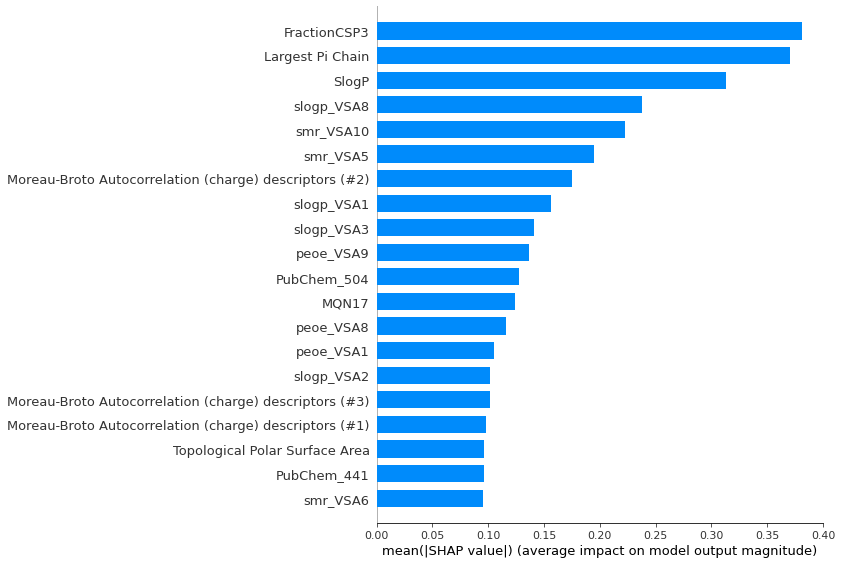

In [100]:
# Summary plot on the train set
print("Expected values: {}".format(explainer_xgb_top_torso.expected_value))
shap.summary_plot(shap_values_train_top_torso, X_train_minmax_top_torso, plot_type='bar');

#### Combining the best estimators
Training and evaluation will be made on a random train/test split.

In [101]:
xgb_models = list()
xgb_models.append(('best_xgb_grid_morgan', best_xgb_grid_morgan))
xgb_models.append(('best_xgb_grid_atom_pair', best_xgb_grid_atom_pair))
xgb_models.append(('best_xgb_grid_top_torso', best_xgb_grid_top_torso))

<p style="color:green; font-size:12"><b>Hard Voting</b></p>

In [102]:
%time
xgb_ensemble_hard = VotingClassifier(xgb_models, voting='hard')
xgb_ensemble_hard.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


VotingClassifier(estimators=[('best_xgb_grid_morgan',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.7,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=6, min_child_weight=1,
                                            missing=-999,
                                            monotone_constraints=...
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=6, min_child_weight=1,
                                            missing=-999,
                                            monotone_constraints='()',
                                            n_estimators=150, n_jobs=8,
                                            num_parallel_tree=1,
                                            predictor='auto',
                                            random_state=233233, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=233233, silent=1,
                                            subsample=0.75, tree_method='exact',
                                            validate_parameters=1,
                                            verbosity=0))])

In [103]:
xgb_ensemble_hard_train_score = f1_score(xgb_ensemble_hard.predict(X_train), y_train , average='weighted' )
xgb_ensemble_hard_test_score  = f1_score(xgb_ensemble_hard.predict(X_test), y_test , average='weighted' )
print("Soft Voter Train Score (F1-weigthed): {}".format(xgb_ensemble_hard_train_score))
print("Soft Voter Test Score (F1-weigthed): {}".format(xgb_ensemble_hard_test_score))

Soft Voter Train Score (F1-weigthed): 0.9984813971146546
Soft Voter Test Score (F1-weigthed): 0.8319680523784915


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


<p style="color:green; font-size:12"><b>Soft Voting</b></p>

In [104]:
%time
xgb_ensemble_soft = VotingClassifier(xgb_models, voting='soft')
xgb_ensemble_soft.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


VotingClassifier(estimators=[('best_xgb_grid_morgan',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.7,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=6, min_child_weight=1,
                                            missing=-999,
                                            monotone_constraints=...
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=6, min_child_weight=1,
                                            missing=-999,
                                            monotone_constraints='()',
                                            n_estimators=150, n_jobs=8,
                                            num_parallel_tree=1,
                                            predictor='auto',
                                            random_state=233233, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=233233, silent=1,
                                            subsample=0.75, tree_method='exact',
                                            validate_parameters=1,
                                            verbosity=0))],
                 voting='soft')

In [105]:
xgb_ensemble_soft_train_score = f1_score(xgb_ensemble_soft.predict(X_train), y_train , average='weighted' )
xgb_ensemble_soft_test_score  = f1_score(xgb_ensemble_soft.predict(X_test), y_test , average='weighted' )
print("Soft Voter Train Score (F1-weigthed): {}".format(xgb_ensemble_soft_train_score))
print("Soft Voter Test Score (F1-weigthed): {}".format(xgb_ensemble_soft_test_score))

Soft Voter Train Score (F1-weigthed): 0.9984813971146546
Soft Voter Test Score (F1-weigthed): 0.8337221960218604


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [106]:
print("This soft voting ensemble classifier was built using three random forest classifiers trained on train/test \
split obtained using different compound selection method. Its weighted **F1 score is {}**, which is higher than the \
**F1 score ({})** of the previous soft voting ensemble classifier that combibed a random forest classifier, a \
support vector classifier, and a gradient boosting classifier.".format(xgb_ensemble_soft_test_score, best_eclf_grid_test_score))

This soft voting ensemble classifier was built using three random forest classifiers trained on train/test split obtained using different compound selection method. Its weighted **F1 score is 0.8337221960218604**, which is higher than the **F1 score (0.8302899691393668)** of the previous soft voting ensemble classifier that combibed a random forest classifier, a support vector classifier, and a gradient boosting classifier.
